# Imports

In [42]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

# Load datasets

In [43]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')

train_targets_a = pd.read_parquet('../data/A/train_targets.parquet')
train_targets_b = pd.read_parquet('../data/B/train_targets.parquet')
train_targets_c = pd.read_parquet('../data/C/train_targets.parquet')

# Data clean up

In [44]:

# Data set A, B and C clean up

def data_clean_up(x_train_est, x_train_observe, y_train):

  if 'date_calc' in x_train_est.columns:
    x_train_est.drop(columns="date_calc", inplace=True)

  x_train = pd.concat([x_train_observe, x_train_est])

  # Group the rows into blocks of 4 and apply the aggregation function
  agg_func = {col: 'mean' for col in x_train.columns[1:]}
  X_train_downscaled = x_train.groupby(x_train.index // 4).agg({**{'date_forecast': 'first'}, **agg_func})

  y_train.dropna(inplace=True)
  combined_data = pd.merge(X_train_downscaled, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'date_forecast' and 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns="date_forecast", inplace=True)
    combined_data.drop(columns="time", inplace=True)
    combined_data.drop(columns="pv_measurement", inplace=True)

  return combined_data, y_train

x_train_a, y_train_a = data_clean_up(X_train_estimated_a, X_train_observed_a, train_targets_a)
x_train_b, y_train_b = data_clean_up(X_train_estimated_b, X_train_observed_b, train_targets_b)
x_train_c, y_train_c = data_clean_up(X_train_estimated_c, X_train_observed_c, train_targets_c)


def data_clean_up_test(x_test_est):

  # Group the rows into blocks of 4 and apply the aggregation function
  agg_func = {col: 'mean' for col in x_test_est.columns[1:]}
  X_test_downscaled = x_test_est.groupby(x_test_est.index // 4).agg({**{'date_forecast': 'first'}, **agg_func})

  if 'date_forecast' in X_test_downscaled.columns:
    X_test_downscaled.drop(columns="date_forecast", inplace=True)

  return X_test_downscaled

x_test_a = data_clean_up_test(X_test_estimated_a)
x_test_b = data_clean_up_test(X_test_estimated_b)
x_test_c = data_clean_up_test(X_test_estimated_c)

# Feature engineering

In [45]:
# Do something

# Training the model

In [46]:
model_a = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, loss_function='RMSE')
model_b = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, loss_function='RMSE')
model_c = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, loss_function='RMSE')

model_a.fit(x_train_a, y_train_a)
model_b.fit(x_train_b, y_train_b)
model_c.fit(x_train_c, y_train_c)

0:	learn: 1104.7443100	total: 21.9ms	remaining: 21.9s
1:	learn: 1026.6420686	total: 28.3ms	remaining: 14.1s
2:	learn: 956.7515097	total: 46.6ms	remaining: 15.5s
3:	learn: 893.6727492	total: 64ms	remaining: 15.9s
4:	learn: 838.7932571	total: 81.1ms	remaining: 16.1s
5:	learn: 789.7962075	total: 98.6ms	remaining: 16.3s
6:	learn: 746.1857826	total: 116ms	remaining: 16.4s
7:	learn: 709.1030761	total: 133ms	remaining: 16.5s
8:	learn: 676.8664314	total: 150ms	remaining: 16.5s
9:	learn: 648.4076596	total: 166ms	remaining: 16.5s
10:	learn: 624.0449504	total: 183ms	remaining: 16.4s
11:	learn: 602.1372930	total: 200ms	remaining: 16.4s
12:	learn: 583.8667058	total: 216ms	remaining: 16.4s
13:	learn: 567.5663735	total: 233ms	remaining: 16.4s
14:	learn: 553.3564619	total: 250ms	remaining: 16.4s
15:	learn: 541.8484033	total: 267ms	remaining: 16.4s
16:	learn: 530.7355827	total: 284ms	remaining: 16.4s
17:	learn: 521.2343402	total: 301ms	remaining: 16.4s
18:	learn: 514.1204433	total: 318ms	remaining: 16.

# Make predictions

In [47]:

y_pred_a = model_a.predict(x_test_a)
y_pred_b = model_b.predict(x_test_b)
y_pred_c = model_c.predict(x_test_c)

y_pred = np.concatenate((y_pred_a, y_pred_b, y_pred_c))

# Evaluate prediction

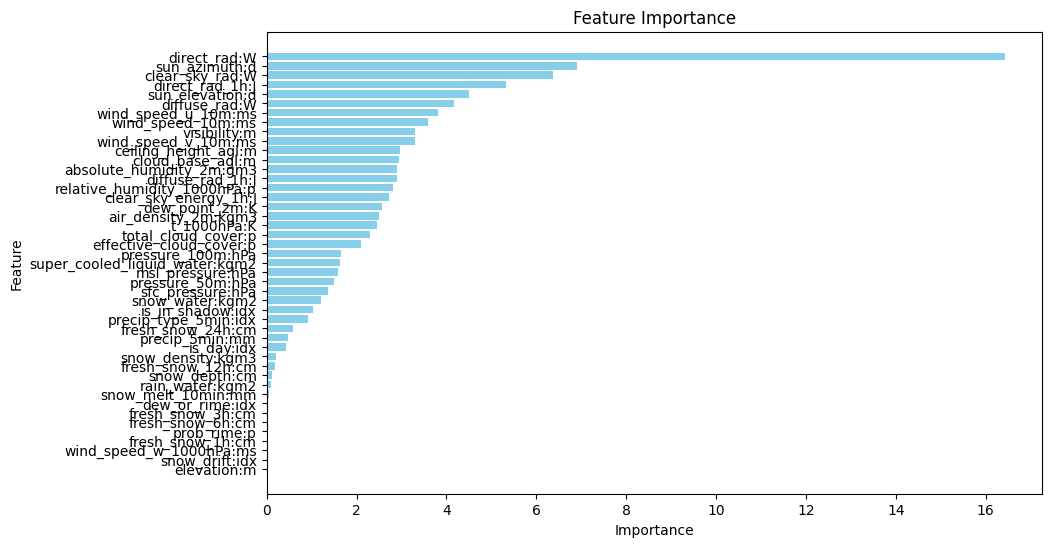

In [48]:
import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

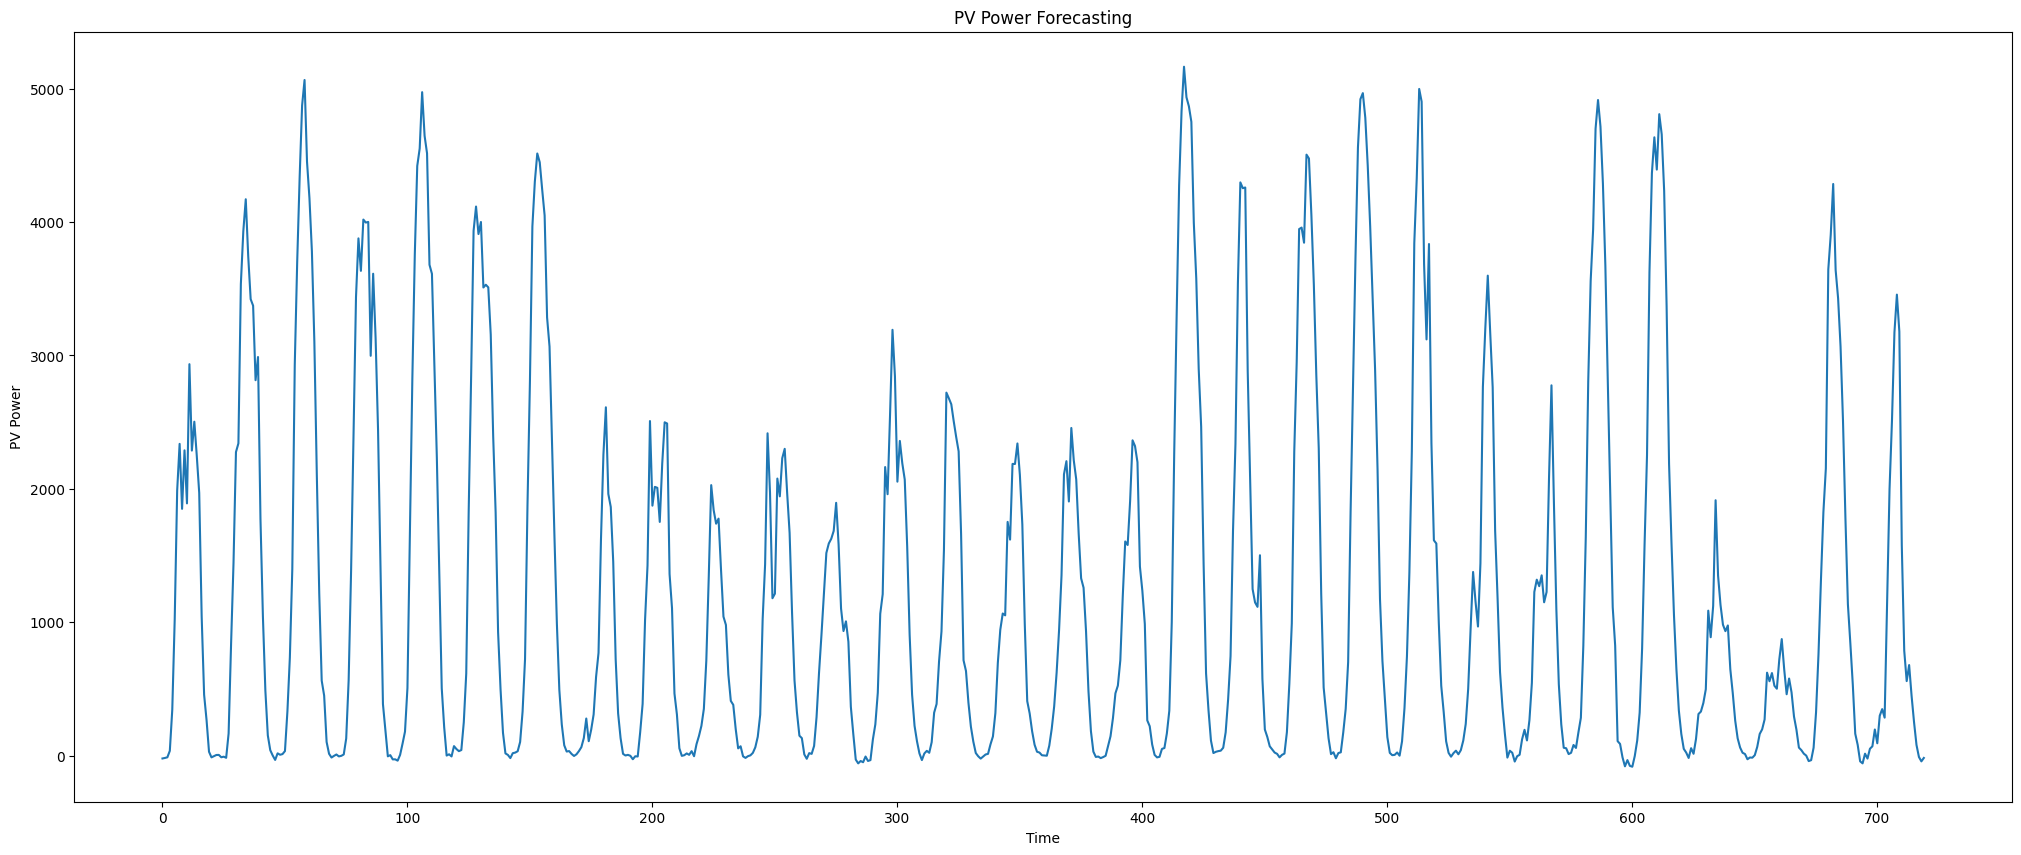

In [49]:

#Plot the results
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.iloc[0:720]
plt.figure(figsize=(25, 10))
plt.plot(y_pred)
plt.title('PV Power Forecasting')
plt.xlabel('Time')
plt.ylabel('PV Power')
plt.show()

# Create submission

In [50]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)